In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Reading our dataset
df = pd.read_csv('RUBY.csv', parse_dates=['Date'])
new_df = df.reset_index()['Close']

# `Define a custom dataset class`

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, index):
        X = self.data[index:index+self.seq_length]
        y = self.data[index+self.seq_length]
        return X, y

# `Normalize the data`

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1, 1))

# `Split into training and testing sets`

In [5]:
train_size = int(len(scaled_data) * 0.8) 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [6]:
n_past = 60

train_dataset = TimeSeriesDataset(train_data, n_past)
test_dataset = TimeSeriesDataset(test_data, n_past)

# `Set the hyperparameters`

In [7]:
input_size = 1
hidden_size = 64
output_size = 1
batch_size = 32
num_epochs = 10000
learning_rate = 0.001
dropout_prob = 0.2
patience = 10

# `Create data loaders`

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# `Stack LSTM model`

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [19]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size, dropout_prob)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# Train the model
def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience):
    best_loss = float('inf')
    best_epoch = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for X, y in train_loader:
            X = X.view(-1, n_past, input_size).float()
            y = y.view(-1, output_size).float()
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X.size(0)
        epoch_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.10f}")

        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for X, y in test_loader:
                X = X.view(-1, n_past, input_size).float()
                y = y.view(-1, output_size).float()
                outputs = model(X)
                loss = criterion(outputs, y)
                test_loss += loss.item() * X.size(0)
            test_loss /= len(test_loader.dataset)
            print(f"Test Loss: {test_loss:.10f}")

        # Check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered. Best loss: {best_loss:.10f} at epoch {best_epoch+1}")
                break

In [22]:
model = LSTMModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience)

Epoch 1/10000, Loss: 0.0367504932
Test Loss: 0.0493934558
Epoch 2/10000, Loss: 0.0143592584
Test Loss: 0.0066009105
Epoch 3/10000, Loss: 0.0057302213
Test Loss: 0.0040738761
Epoch 4/10000, Loss: 0.0039726782
Test Loss: 0.0033398179
Epoch 5/10000, Loss: 0.0031174754
Test Loss: 0.0018211931
Epoch 6/10000, Loss: 0.0027182587
Test Loss: 0.0019815484
Epoch 7/10000, Loss: 0.0026505050
Test Loss: 0.0020623283
Epoch 8/10000, Loss: 0.0025611182
Test Loss: 0.0028610891
Epoch 9/10000, Loss: 0.0026470337
Test Loss: 0.0019116843
Epoch 10/10000, Loss: 0.0023041630
Test Loss: 0.0018594419
Epoch 11/10000, Loss: 0.0021099819
Test Loss: 0.0013626101
Epoch 12/10000, Loss: 0.0020745701
Test Loss: 0.0013141381
Epoch 13/10000, Loss: 0.0018742712
Test Loss: 0.0016998384
Epoch 14/10000, Loss: 0.0019683488
Test Loss: 0.0013590493
Epoch 15/10000, Loss: 0.0019617596
Test Loss: 0.0020469565
Epoch 16/10000, Loss: 0.0017211409
Test Loss: 0.0012135245
Epoch 17/10000, Loss: 0.0016721452
Test Loss: 0.0014724902
Epoch 

In [24]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = 0.0
    predictions = []
    for X, y in test_loader:
        X = X.view(-1, n_past, input_size).float()
        y = y.view(-1, output_size).float()
        outputs = model(X)
        loss = criterion(outputs, y)
        test_loss += loss.item() * X.size(0)
        predictions.extend(outputs.tolist())
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0007331161


In [25]:
# Inverse scale the data
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_values = scaler.inverse_transform(test_data[n_past:])

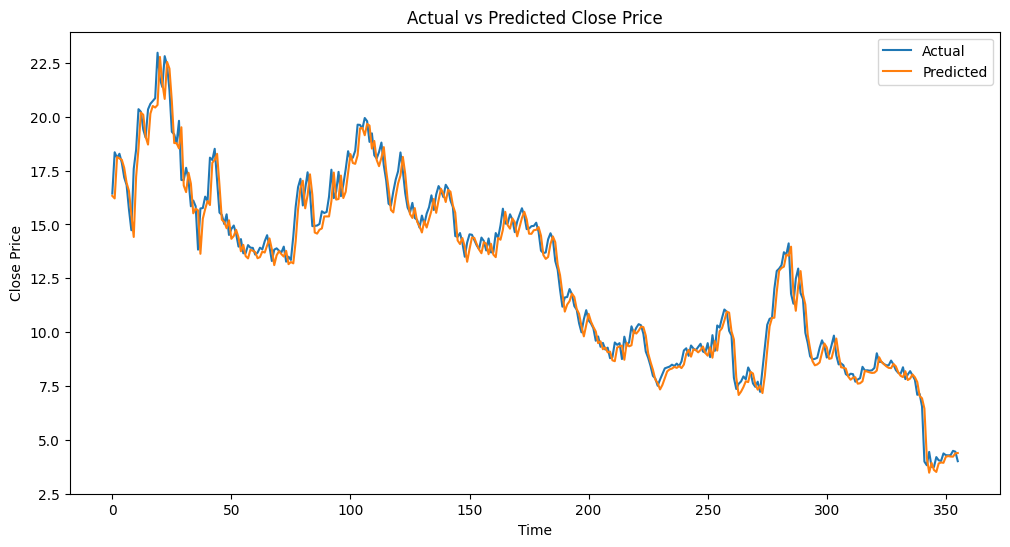

In [26]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

In [27]:
input_sequence = test_data[-n_past:].reshape(1, n_past, input_size)
input_sequence = torch.from_numpy(input_sequence).float()

model.eval()

with torch.no_grad():
    predicted_sequence = model(input_sequence)

if scaled_data.shape[0] > 1:
    predicted_sequence = scaler.inverse_transform(predicted_sequence.numpy())

print("Predicted Sequence:")
print(predicted_sequence.squeeze().tolist())

Predicted Sequence:
4.01864767074585


# `BiLSTMModel`

In [28]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size*2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.bilstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [29]:
model = BiLSTMModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, test_loader, criterion, optimizer, num_epochs, patience)

Epoch 1/10000, Loss: 0.0337225298
Test Loss: 0.0311304244
Epoch 2/10000, Loss: 0.0093413908
Test Loss: 0.0047022582
Epoch 3/10000, Loss: 0.0042093707
Test Loss: 0.0022687077
Epoch 4/10000, Loss: 0.0028750128
Test Loss: 0.0020865351
Epoch 5/10000, Loss: 0.0024981796
Test Loss: 0.0020377571
Epoch 6/10000, Loss: 0.0021936762
Test Loss: 0.0013172213
Epoch 7/10000, Loss: 0.0019932108
Test Loss: 0.0012256089
Epoch 8/10000, Loss: 0.0018438692
Test Loss: 0.0010889056
Epoch 9/10000, Loss: 0.0015992464
Test Loss: 0.0010473646
Epoch 10/10000, Loss: 0.0016144476
Test Loss: 0.0009690620
Epoch 11/10000, Loss: 0.0014256675
Test Loss: 0.0009263114
Epoch 12/10000, Loss: 0.0015329791
Test Loss: 0.0009031638
Epoch 13/10000, Loss: 0.0013490491
Test Loss: 0.0009252238
Epoch 14/10000, Loss: 0.0013283360
Test Loss: 0.0008261679
Epoch 15/10000, Loss: 0.0012590040
Test Loss: 0.0009042513
Epoch 16/10000, Loss: 0.0011942801
Test Loss: 0.0009603091
Epoch 17/10000, Loss: 0.0011638148
Test Loss: 0.0010176504
Epoch 

In [30]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = 0.0
    predictions = []
    for X, y in test_loader:
        X = X.view(-1, n_past, input_size).float()
        y = y.view(-1, output_size).float()
        outputs = model(X)
        loss = criterion(outputs, y)
        test_loss += loss.item() * X.size(0)
        predictions.extend(outputs.tolist())
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0007244235


In [31]:
# Inverse scale the data
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_values = scaler.inverse_transform(test_data[n_past:])

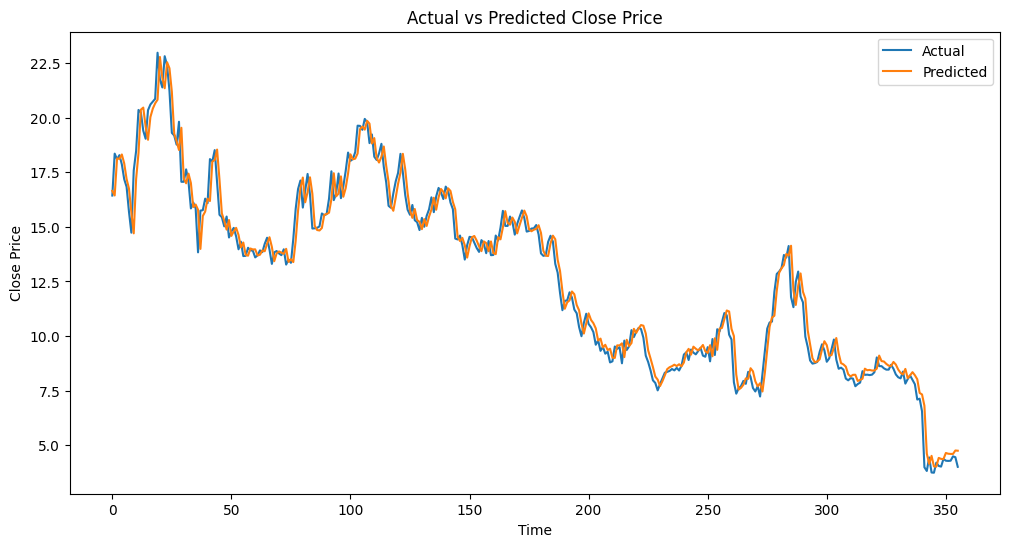

In [32]:
# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

In [33]:
input_sequence = test_data[-n_past:].reshape(1, n_past, input_size)
input_sequence = torch.from_numpy(input_sequence).float()

model.eval()

with torch.no_grad():
    predicted_sequence = model(input_sequence)

if scaled_data.shape[0] > 1:
    predicted_sequence = scaler.inverse_transform(predicted_sequence.numpy())

print("Predicted Sequence:")
print(predicted_sequence.squeeze().tolist())

Predicted Sequence:
4.389575958251953
